In [1]:
from pathlib import Path
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Subset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import sys

# Add project root to sys.path if it does not exist
project_root = str(Path().resolve().parents[0])
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.autoaugment import ImageNetPolicy

In [2]:
# Define augmentations to be carried out
train_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    ImageNetPolicy(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # transforms.RandomErasing(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transformers = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Load the train dataset
# train_data = datasets.ImageFolder("/content/drive/MyDrive/car-classification-api/data/train")
train_data = datasets.ImageFolder("../../data/train")

# Split the data further into train and val sets
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_indices, val_indices = random_split(range(len(train_data)), [train_size, val_size])
# train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, indices, transform=None):
        self.original_dataset = Subset(original_dataset, indices)
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        img, label = self.original_dataset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
# Define train and validation datasets with separate transforms
train_dataset = CustomDataset(train_data, train_indices, transform=train_transformers)
val_dataset = CustomDataset(train_data, val_indices, transform=val_transformers)

In [6]:
img, label = train_dataset[3]  # Replace 0 with any valid index
print(type(img))  # Should show <class 'torch.Tensor'>
print(img.shape)  # Should show [3, 224, 224] or similar

<class 'torch.Tensor'>
torch.Size([3, 224, 224])


In [7]:
for i in range(15):  # Inspect the first 5 samples
  img, label = train_dataset[i]
  print(f"Sample {i}: Type - {type(img)}, Shape - {img.shape}")

Sample 0: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 1: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 2: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 3: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 4: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 5: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 6: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 7: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 8: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 9: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 10: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 11: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 12: Type - <class 'torch.Tensor'>, Shape - torch.Size([3, 224, 224])
Sample 13: Type - <cla

In [8]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
# for inputs, labels in train_loader:
#     print(type(inputs), inputs.shape)  # Should work without error
#     break

In [10]:
# inputs, labels = next(iter(train_loader))
# print(inputs.shape, labels.shape)

In [11]:
# Load pre-trained model, EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Modify final classification layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(train_data.classes))

/Users/jas/anaconda3/envs/car-classification/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jas/anaconda3/envs/car-classification/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [20]:
# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# print(device)

cpu


In [13]:
# Check for MPS support (for Mac GPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS (Metal Performance Shaders)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Fallback to CUDA or CPU

# Move model to the selected device
model = model.to(device)
print(f"Using device: {device}")

Using device: mps


In [14]:
# Define the save path relative to the project root
save_dir = os.path.join(project_root, 'models')
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

In [15]:
save_dir

'/Users/jas/Documents/car-classification-api/models'

In [16]:
project_root

'/Users/jas/Documents/car-classification-api'

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop + eval on val
epochs = 10

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')

for epoch in range(epochs):
    # Training 
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Predictions for training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    # Val
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Predictions for val accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print metrics 
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Correct Predictions: {correct_train}/{total_train}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Correct Predictions: {correct_val}/{total_val}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(save_dir, 'efficientnet_b0_autoaugment_state_dict.pth'))
        torch.save(model, os.path.join(save_dir, 'efficientnet_b0_autoaugment_entire_model.pth'))
        print(f"Best model saved in {save_dir}.")

Epoch 1/10
Train Loss: 4.5917, Train Accuracy: 7.24%, Correct Predictions: 472/6515
Val Loss: 3.3065, Val Accuracy: 19.28%, Correct Predictions: 314/1629
Best model saved in /Users/jas/Documents/car-classification-api/models.
Epoch 2/10
Train Loss: 2.6343, Train Accuracy: 33.52%, Correct Predictions: 2184/6515
Val Loss: 1.7778, Val Accuracy: 50.46%, Correct Predictions: 822/1629
Best model saved in /Users/jas/Documents/car-classification-api/models.
Epoch 3/10
Train Loss: 1.6618, Train Accuracy: 55.00%, Correct Predictions: 3583/6515
Val Loss: 1.3326, Val Accuracy: 61.14%, Correct Predictions: 996/1629
Best model saved in /Users/jas/Documents/car-classification-api/models.
Epoch 4/10
Train Loss: 1.1312, Train Accuracy: 67.81%, Correct Predictions: 4418/6515
Val Loss: 1.0971, Val Accuracy: 68.57%, Correct Predictions: 1117/1629
Best model saved in /Users/jas/Documents/car-classification-api/models.
Epoch 5/10
Train Loss: 0.8934, Train Accuracy: 74.38%, Correct Predictions: 4846/6515
Val

In [18]:
# Load the test dataset
test_data = datasets.ImageFolder("../../data/test", transform=test_transformers)

In [19]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [20]:
y_true, y_pred = [], []

model.eval()
correct = 0
total = 0
test_loss = 0.0
processed_images = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        processed_images += labels.size(0)
        if processed_images % 500 == 0 or processed_images == total:
            print(f"Processed {processed_images} / {len(test_loader.dataset)} images...")

# Calculate metrics
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=test_data.classes, columns=test_data.classes)
print(cm_df)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Processed 32 / 8041 images...
Processed 64 / 8041 images...
Processed 96 / 8041 images...
Processed 128 / 8041 images...
Processed 160 / 8041 images...
Processed 192 / 8041 images...
Processed 224 / 8041 images...
Processed 256 / 8041 images...
Processed 288 / 8041 images...
Processed 320 / 8041 images...
Processed 352 / 8041 images...
Processed 384 / 8041 images...
Processed 416 / 8041 images...
Processed 448 / 8041 images...
Processed 480 / 8041 images...
Processed 512 / 8041 images...
Processed 544 / 8041 images...
Processed 576 / 8041 images...
Processed 608 / 8041 images...
Processed 640 / 8041 images...
Processed 672 / 8041 images...
Processed 704 / 8041 images...
Processed 736 / 8041 images...
Processed 768 / 8041 images...
Processed 800 / 8041 images...
Processed 832 / 8041 images...
Processed 864 / 8041 images...
Processed 896 / 8041 images...
Processed 928 / 8041 images...
Processed 960 / 8041 images...
Processed 992 / 8041 images...
Processed 1024 / 8041 images...
Processed 

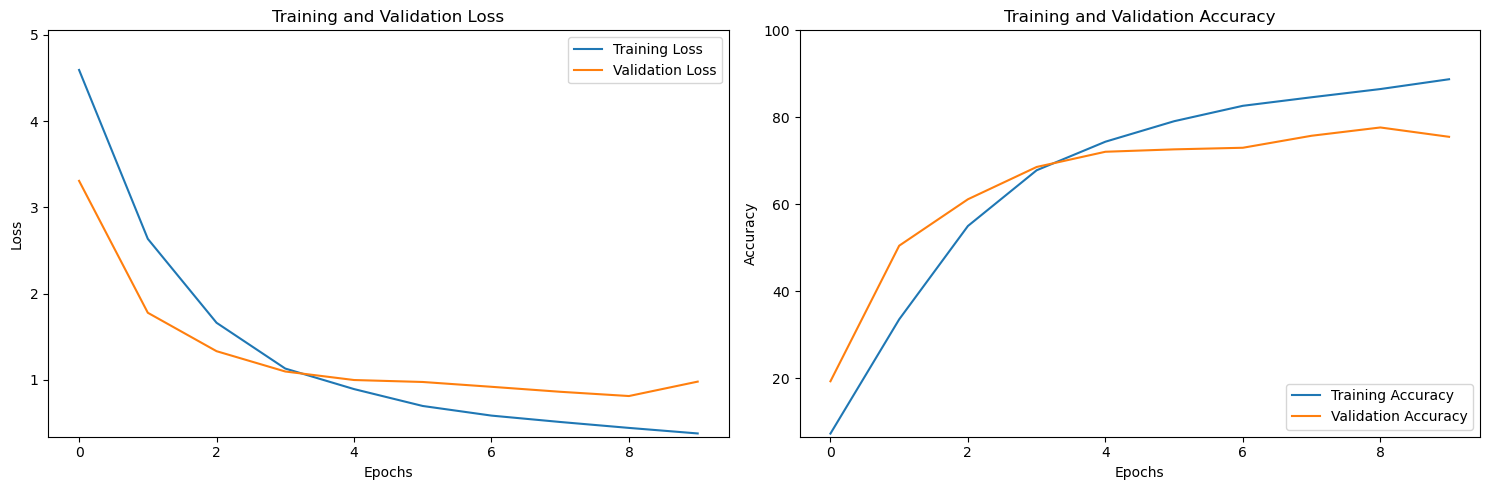

In [21]:
plt.figure(figsize=(15, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([min(min(train_losses), min(val_losses)) * 0.9, max(max(train_losses), max(val_losses)) * 1.1])
plt.title('Training and Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([min(min(train_accuracies), min(val_accuracies)) * 0.9, 100])
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [22]:
import seaborn as sns

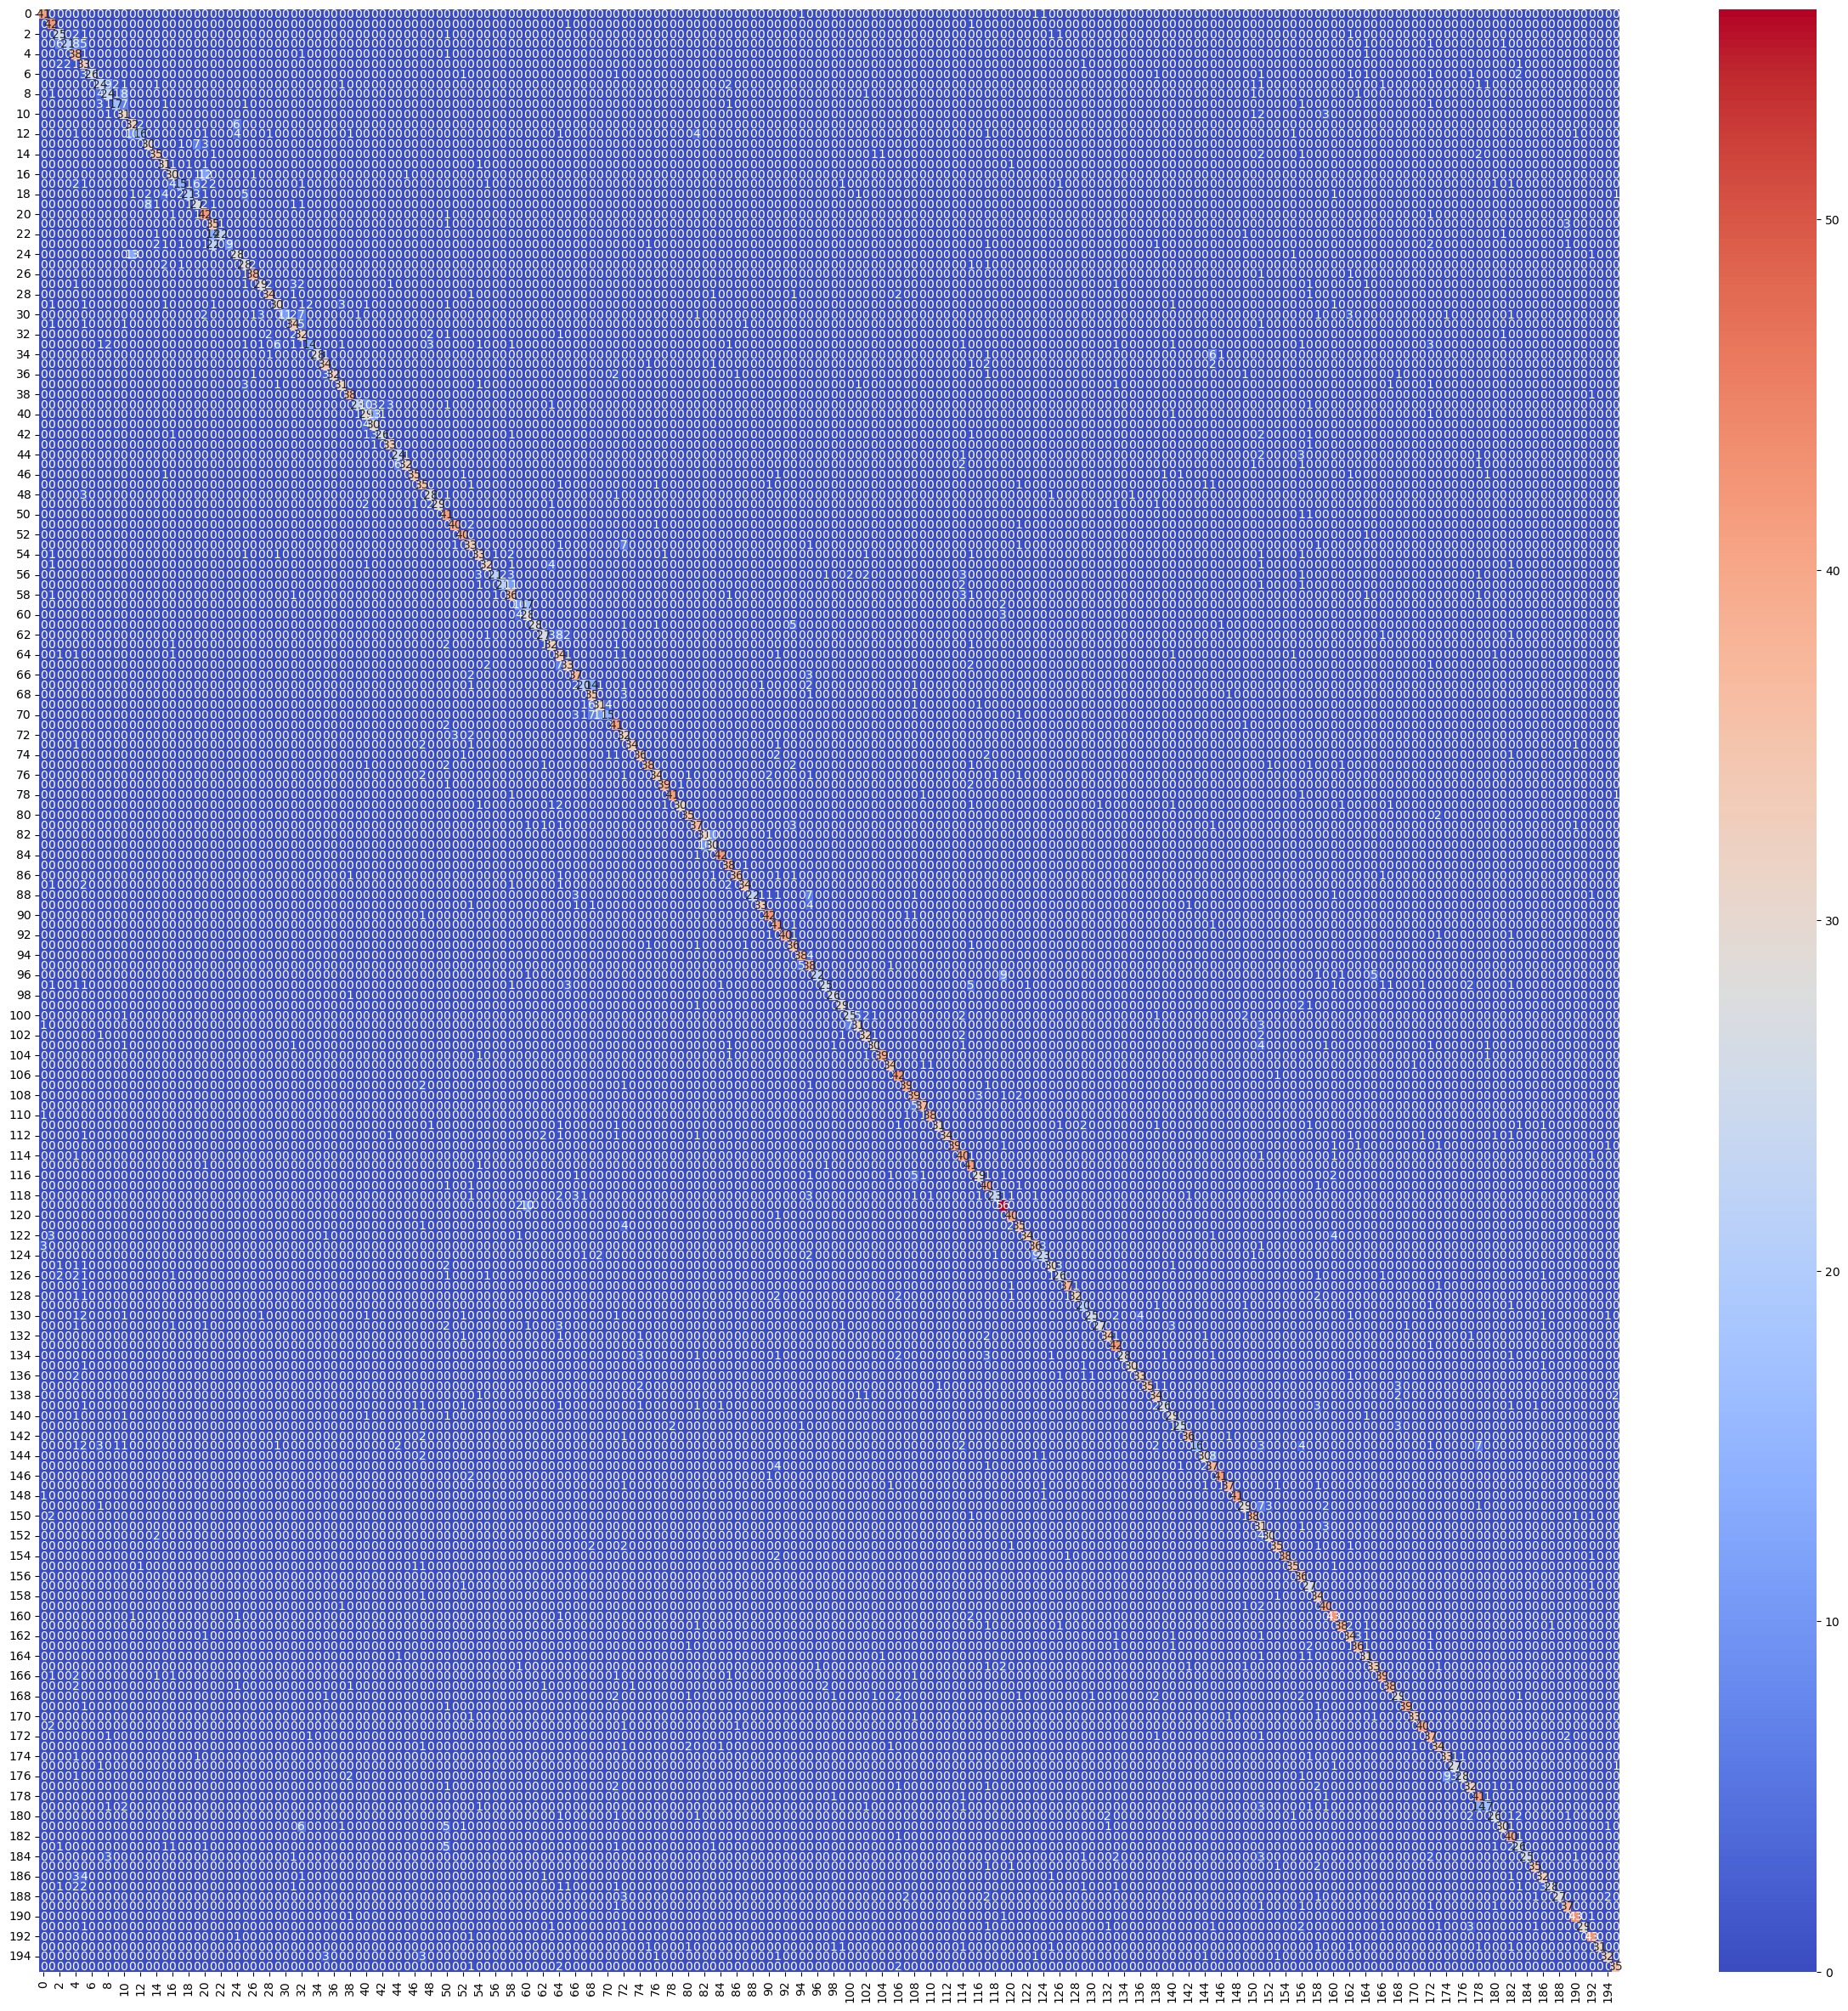

In [23]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")  # Customize as needed
plt.show()

In [24]:
# Flatten the confusion matrix DataFrame into a long format for filtering
cm_long = cm_df.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
cm_long = cm_long.rename(columns={'index': 'Actual'})

# Filter for misclassifications (Actual != Predicted) where the count is greater than 10
misclassified = cm_long[(cm_long['Actual'] != cm_long['Predicted']) & (cm_long['Count'] > 10)]

# Sort for better visibility
misclassified = misclassified.sort_values(by='Count', ascending=False)

# Display or save
print(misclassified)

                                                Actual  \
4139                               Audi TTS Coupe 2012   
11819                 Chevrolet Express Cargo Van 2007   
4138                             Audi TT RS Coupe 2012   
13395       Chevrolet Silverado 1500 Extended Cab 2012   
35067                             Spyker C8 Coupe 2009   
2180                                Audi V8 Sedan 1994   
8076                 Bentley Continental GT Coupe 2007   
3936                                Audi S4 Sedan 2007   
11425  Chevrolet Corvette Ron Fellows Edition Z06 2007   
13594      Chevrolet Silverado 2500HD Regular Cab 2012   

                                           Predicted  Count  
4139                          Audi TT Hatchback 2011     22  
11819                     Chevrolet Express Van 2007     17  
4138                          Audi TT Hatchback 2011     14  
13395  Chevrolet Silverado 1500 Hybrid Crew Cab 2012     14  
35067                     Spyker C8 Convertible 200